In [1]:
import pandas as pd 

from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
data_df = pd.read_csv("final_data/averages.csv", index_col=0)

data_df = data_df.dropna()

betting = pd.read_csv("final_data/betting.csv")

In [59]:
data_df

,team,team_opp,season,date,mp,fg,fga,fg%,3p,3pa,...,ast%_max_opp,stl%_max_opp,blk%_max_opp,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,total_opp,won_opp,target
15,IND,MEM,2016,2015-10-29,0.000000,0.241379,0.340426,0.282443,0.333333,0.221374,...,0.203085,0.605769,0.179002,0.306442,0.355097,0.000000,0.474576,0.000000,0.000000,0
16,NYK,ATL,2016,2015-10-29,0.000000,0.586207,0.489362,0.587786,0.333333,0.221374,...,0.159383,0.432692,0.244406,0.483444,0.201604,0.793103,0.508475,0.290323,0.000000,0
17,SAC,LAL,2016,2015-10-30,0.000000,0.551724,0.510638,0.526718,0.444444,0.244275,...,0.017995,0.081731,0.185886,0.196869,0.268041,0.349754,0.423729,0.564516,0.000000,1
18,PHI,UTA,2016,2015-10-30,0.000000,0.310345,0.276596,0.427481,0.222222,0.198473,...,0.213368,0.182692,0.240964,0.196869,0.164948,0.152709,0.322034,0.177419,0.000000,0
19,BOS,TOR,2016,2015-10-30,0.000000,0.482759,0.319149,0.614504,0.277778,0.244275,...,0.102828,0.048077,0.165232,1.000000,0.107675,0.182266,0.237288,0.483871,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6534,GSW,SAC,2022,2021-12-20,0.020000,0.533793,0.343830,0.657710,0.660000,0.633588,...,0.163239,0.134081,0.274877,0.175775,0.160451,0.333881,0.529190,0.549582,0.407407,1
6535,BOS,PHI,2022,2021-12-20,0.092593,0.492976,0.378251,0.571671,0.528807,0.519084,...,0.190825,0.247041,0.456905,0.288334,0.193233,0.428761,0.485658,0.459677,0.500000,0
6536,CHI,HOU,2022,2021-12-20,0.000000,0.506207,0.356596,0.607634,0.442222,0.376183,...,0.265523,0.239460,0.333907,0.435280,0.168914,0.374195,0.505215,0.469603,0.307692,1
6537,MEM,OKC,2022,2021-12-20,0.034483,0.576694,0.454145,0.606344,0.515326,0.482759,...,0.211606,0.201923,0.351246,0.275894,0.216028,0.392264,0.478970,0.375149,0.333333,0


In [4]:
removed_columns = ["season", "date", "won", "target", "team", "team_opp"]
selected_columns = data_df.columns[~data_df.columns.isin(removed_columns)]


scaler = MinMaxScaler()
data_df[selected_columns] = scaler.fit_transform(data_df[selected_columns])

In [5]:
data_df_train_val = data_df[data_df.season != 2022]

target_train_val = data_df.target

data_df_test = data_df[data_df.season == 2022]

target_test = data_df_test.target

betting_test = betting[betting.season == 2022]

In [6]:
model = LogisticRegression()
# model = SVC(probability=True)
# model = MLPClassifier()
# model = DecisionTreeClassifier()

In [7]:
split = TimeSeriesSplit(n_splits=6)

sfs = SequentialFeatureSelector(model, 
                                n_features_to_select=30, 
                                direction="forward",
                                cv=split,
                                n_jobs=1
                               )

In [8]:
sfs.fit(data_df_train_val[selected_columns], data_df_train_val["target"])

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None),
                          estimator=LogisticRegression(),
                          n_features_to_select=30, n_jobs=1)

In [12]:
predictors = list(selected_columns[sfs.get_support()])

In [20]:
model_fitted = model.fit(data_df_train_val[predictors], data_df_train_val["target"])

In [9]:
def moneyline_to_decimal(moneyline):
    if moneyline > 0:
        return (moneyline / 100) + 1
    else:
        return (100 / abs(moneyline)) + 1

In [10]:
def calculate_return(moneyline_odds, bet_amount):
    if moneyline_odds > 0:
        return bet_amount * (moneyline_odds / 100) + bet_amount
    else:
        return bet_amount * (100 / abs(moneyline_odds)) + bet_amount

In [99]:
def backtest(data, betting, target, model, predictors):

    principal = 1000 

    principal_over_time = [principal]

    for (i,data_row),(j,betting_row), (k, target) in zip(data[predictors].iterrows(), betting.iterrows(), target.items()):

        home_decimal_odds = moneyline_to_decimal(betting_row["HomeML"])

        away_decimal_odds = moneyline_to_decimal(betting_row["AwayML"])

        prediction_row = pd.DataFrame(data_row).T
    
        home_or_away = model.predict(prediction_row)

        away_prob,home_prob = model.predict_proba(prediction_row)[0]

        if home_or_away == 0:
            bet = principal*(home_prob - away_prob/home_decimal_odds)

            odds = home_decimal_odds

            predicted_prob = home_prob
        else:
            bet = principal*(away_prob - home_prob/away_decimal_odds)

            odds = away_decimal_odds

            predicted_prob = away_prob
        
        principal -= bet

        if home_or_away == target:
            principal += calculate_return(odds, bet)
        
        principal_over_time.append(principal)
    
    return principal_over_time

In [100]:
principal_over_time = backtest(data_df_test, betting_test, target_test, model_fitted, predictors)

In [101]:
import seaborn as sns

<Axes: >

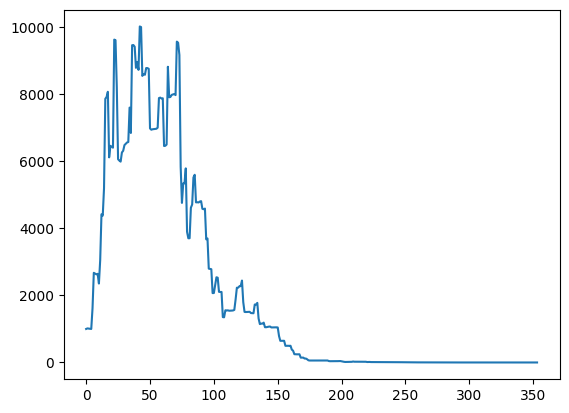

In [102]:
sns.lineplot(x=range(len(principal_over_time)), y=principal_over_time)